In [ ]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

from torch.distributions.normal import Normal

In [ ]:
# Latent dimensions
z = 10
# Training iterations
iter_max = 50
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Load dataset

In [ ]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)
train_loader

100%|██████████| 9912422/9912422 [00:00<00:00, 113483836.15it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 57573998.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28164327.33it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23317660.67it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Utility Functions
- Complete the code for the function ```sample_gaussian```

In [ ]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    ################################################################################
    # TODO: complete the code here
    # Task: Sample z
    batch, dim = m.shape

    # generate a sample for each data point from a normal distribution
    epsilon = Normal(0, 1).sample((batch, dim)).to(m.device)

    # apply reparameterization trick
    z = m + (torch.sqrt(v) * epsilon)

    # End
    ################################################################################

    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

def duplicate(x, rep):
    """
    Duplicates x along dim=0

    Args:
        x: tensor: (batch, ...): Arbitrary tensor
        rep: int: (): Number of replicates. Setting rep=1 returns orignal x

    Returns:
        _: tensor: (batch * rep, ...): Arbitrary replicated tensor
    """
    return x.expand(rep, *x.shape).reshape(-1, *x.shape[1:])

def log_normal(x, m, v):
    """
    Computes the elem-wise log probability of a Gaussian and then sum over the
    last dim. Basically we're assuming all dims are batch dims except for the
    last dim.

    Args:
        x: tensor: (batch_1, batch_2, ..., batch_k, dim): Observation
        m: tensor: (batch_1, batch_2, ..., batch_k, dim): Mean
        v: tensor: (batch_1, batch_2, ..., batch_k, dim): Variance

    Return:
        log_prob: tensor: (batch_1, batch_2, ..., batch_k): log probability of
            each sample. Note that the summation dimension is not kept
    """
    log_std = torch.log(torch.sqrt(v))
    log_probs = -((x - m) ** 2) / (2 * v) - log_std - np.log(np.sqrt(2 * np.pi))
    log_prob = log_probs.sum(-1)

    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob

def log_mean_exp(x, dim):
    """
    Compute the log(mean(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which mean is computed

    Return:
        _: tensor: (...): log(mean(exp(x), dim))
    """
    return log_sum_exp(x, dim) - np.log(x.size(dim))

def log_sum_exp(x, dim=0):
    """
    Compute the log(sum(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which sum is computed

    Return:
        _: tensor: (...): log(sum(exp(x), dim))
    """
    max_x = torch.max(x, dim)[0]
    new_x = x - max_x.unsqueeze(dim).expand_as(x)
    return max_x + (new_x.exp().sum(dim)).log()

### Base Models

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

- Complete the functions ```negative_elbo_bound``` and ```negative_iwae_bound```. Make sure to use functions provided in the ***Utility*** and ***Base Model*** sections for your benefit when completing the code.

In [ ]:
class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim

        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl_loss: tensor: (): ELBO KL divergence to prior
            rec_loss: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: complete the code here
        # Task: Compute negative Evidence Lower Bound and its KL and Reconstruction term
        # Note that nelbo = kl + rec
        # Outputs should all be scalar

        """pass input through encoder and decoder"""
        m, v = self.enc.encode(x)
        z = sample_gaussian(m, v)
        x_hat = self.dec.decode(z) #torch.sigmoid()

        """compute reconstruction """
        # Using util fnuction that calculates BCE

        recon_loss = log_bernoulli_with_logits(x, x_hat) # .mean(dim=0)


        """compute KL divergence of two normal distributions"""
        kl_loss = kl_normal(m, v, self.z_prior_m, self.z_prior_v) #.mean(dim=0)


        """ compute negative elbo bound"""
        nelbo = kl_loss - recon_loss

        # End
        ################################################################################

        return nelbo.mean(dim=0), kl_loss.mean(dim=0), recon_loss.mean(dim=0)

    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: Modify/complete the code here
        # Compute niwae (negative IWAE) with iw importance samples, and the KL
        # and Rec decomposition of the Evidence Lower Bound
        #
        # Outputs should all be scalar
        ################################################################################
        """ We want to have k samples for each generated z """
        m, v = self.enc.encode(x)
        z = sample_gaussian(m, v)
        z = duplicate(z, iw)
        x_hat = self.dec.decode(z)

        """ Reconstruction error is calculated as before on the samples """
        rec = log_bernoulli_with_logits(duplicate(x, iw), x_hat).mean(dim=0)

        """ KL is the other part of formula that is needed to calculate IWAE """
        kl = kl_normal(m, v, self.z_prior_m, self.z_prior_v).mean(dim=0)

        """ Log weights is the result of what goes in the expectation """
        log_weights = log_bernoulli_with_logits(duplicate(x, iw), x_hat) - kl


        niwae = -(log_mean_exp(log_weights, dim=-1))

        ################################################################################
        # End of code modification
        ################################################################################
        return niwae, kl, rec


    def loss(self, x):
        # nelbo, kl, rec = self.negative_elbo_bound(x)##################################################iwae
        # loss = nelbo

        # summaries = dict((
        #     ('train/loss', nelbo),
        #     ('gen/elbo', -nelbo),
        #     ('gen/kl_z', kl),
        #     ('gen/rec', rec),
        # ))

        niwae, kl, rec = self.negative_iwae_bound(x, 5)
        loss = niwae
        summaries = dict((
            ('train/loss', niwae),
            ('gen/elbo', -niwae),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))

        return loss, summaries

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


### Run model

- You will probably need to add some lines to this code. (Add test set, save statistics and plot, ...)

Note that Negative ELBO on the test set should be around 100.

#### Util functions

In [ ]:
import csv


def save_report(train_loss, train_kl, train_rec, test_loss, test_kl, test_rec):
    file_path = "/content/report.csv"
    rows = zip(train_loss, train_kl, train_rec, test_loss, test_kl, test_rec)
    headers = ['train_nelbo', 'train_kl', 'train_recon', 'test_nelbo', 'test_kl', 'test_recon']

    with open(file_path, "w") as f:
        writer = csv.writer(f)
        writer.writerow([g for g in headers])
        for row in rows:
            writer.writerow(row)
    return

In [ ]:
import matplotlib.pyplot as plt
def plot_acc_loss(train_loss, train_kl, train_rec, test_loss, test_kl, test_rec):
    _, axes = plt.subplots(1, 3, figsize=(16, 4))
    plt.suptitle("NELBO, KL  and Reconstruction for train and test data", size=14)
    train_kl = [x for x in train_kl]
    test_kl = [x for x in test_kl]
    axes[0].plot(list(range(1, len(train_kl)+1)), train_kl, 'b',label='train accuracy')
    axes[0].plot(list(range(1, len(train_kl)+1)), test_kl, 'r', label='test accuracy')
    axes[0].set_ylabel('KL ', size=12, labelpad=7)
    axes[0].set_xlabel('Epoch', size=12, labelpad=10)
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid()

    axes[1].plot(list(range(1, len(train_kl)+1)), train_loss, 'b', label='train loss')
    axes[1].plot(list(range(1, len(train_kl)+1)), test_loss, 'r',label='test loss')
    axes[1].set_ylabel('NELBO', size=12, labelpad=5)
    axes[1].set_xlabel('Epoch', size=12, labelpad=10)
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid()

    axes[2].plot(list(range(1, len(train_kl)+1)), train_rec, 'b', label='train rec')
    axes[2].plot(list(range(1, len(train_kl)+1)), test_rec, 'r',label='test rec')
    axes[2].set_ylabel('Reconstruction', size=12, labelpad=7)
    axes[2].set_xlabel('Epoch', size=12, labelpad=10)
    axes[2].legend(loc='best', fontsize=10)
    axes[2].grid()

    plt.show()

In [ ]:
def validation(model, epoch):
    val_loss = 0
    val_kl = 0
    val_recon = 0
    model.eval()
    with torch.no_grad():
        loop_valid = tqdm(enumerate(test_loader, 1), total=len(test_loader), desc="validation", position=0, leave=True)
        for index, (xu, yu) in loop_valid:

            optimizer.zero_grad()

            xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
            yu = yu.new(np.eye(10)[yu]).to(device).float()
            loss, summaries = model.loss(xu)

            loop_valid.set_description(f"Validation - epoch : {epoch}")
            loop_valid.set_postfix(
                    nelbo="{}".format(summaries['train/loss'].detach().cpu().numpy()),
                    KL   ="{}".format(summaries['gen/kl_z'].detach().cpu().numpy()),
                    rec  ="{}".format(summaries['gen/rec'].detach().cpu().numpy()),
                    refresh=True,
            )
            val_loss  += summaries['train/loss'].detach().cpu().numpy()
            val_kl    += summaries['gen/kl_z'].detach().cpu().numpy()
            val_recon += summaries['gen/rec'].detach().cpu().numpy()
    print('\n')
    return val_loss/len(test_loader), val_kl/len(test_loader), val_recon/len(test_loader)

#### Train

  2%|▏         | 1/50 [00:15<12:27, 15.26s/it]

  4%|▍         | 2/50 [00:30<12:16, 15.34s/it]

  6%|▌         | 3/50 [00:45<11:53, 15.18s/it]

  8%|▊         | 4/50 [01:00<11:35, 15.12s/it]

 10%|█         | 5/50 [01:15<11:22, 15.17s/it]

 12%|█▏        | 6/50 [01:30<11:05, 15.12s/it]

 14%|█▍        | 7/50 [01:46<10:49, 15.10s/it]

 16%|█▌        | 8/50 [02:01<10:37, 15.17s/it]

 18%|█▊        | 9/50 [02:16<10:19, 15.12s/it]

 20%|██        | 10/50 [02:31<10:06, 15.15s/it]

 22%|██▏       | 11/50 [02:47<09:55, 15.28s/it]

 24%|██▍       | 12/50 [03:02<09:40, 15.29s/it]

 26%|██▌       | 13/50 [03:17<09:25, 15.27s/it]

 28%|██▊       | 14/50 [03:32<09:08, 15.23s/it]

 30%|███       | 15/50 [03:47<08:51, 15.17s/it]

 32%|███▏      | 16/50 [04:02<08:33, 15.12s/it]

 34%|███▍      | 17/50 [04:17<08:17, 15.08s/it]

 36%|███▌      | 18/50 [04:32<08:01, 15.06s/it]

 38%|███▊      | 19/50 [04:48<07:49, 15.15s/it]

 40%|████      | 20/50 [05:03<07:35, 15.19s/it]

 42%|████▏     | 21/50 [05:18<07:20, 15.18s/it]

 44%|████▍     | 22/50 [05:33<07:06, 15.22s/it]

 46%|████▌     | 23/50 [05:49<06:50, 15.19s/it]

 48%|████▊     | 24/50 [06:04<06:37, 15.28s/it]

 50%|█████     | 25/50 [06:19<06:21, 15.27s/it]

 52%|█████▏    | 26/50 [06:35<06:07, 15.31s/it]

 54%|█████▍    | 27/50 [06:50<05:53, 15.37s/it]

 56%|█████▌    | 28/50 [07:06<05:39, 15.43s/it]

 58%|█████▊    | 29/50 [07:21<05:23, 15.42s/it]

 60%|██████    | 30/50 [07:36<05:07, 15.39s/it]

 62%|██████▏   | 31/50 [07:52<04:53, 15.46s/it]

 64%|██████▍   | 32/50 [08:08<04:39, 15.52s/it]

 66%|██████▌   | 33/50 [08:23<04:22, 15.47s/it]

 68%|██████▊   | 34/50 [08:39<04:07, 15.47s/it]

 70%|███████   | 35/50 [08:54<03:51, 15.44s/it]

 72%|███████▏  | 36/50 [09:10<03:37, 15.54s/it]

 74%|███████▍  | 37/50 [09:25<03:21, 15.46s/it]

 76%|███████▌  | 38/50 [09:41<03:05, 15.49s/it]

 78%|███████▊  | 39/50 [09:56<02:50, 15.52s/it]

 80%|████████  | 40/50 [10:12<02:36, 15.62s/it]

 82%|████████▏ | 41/50 [10:28<02:21, 15.68s/it]

 84%|████████▍ | 42/50 [10:43<02:05, 15.64s/it]

 86%|████████▌ | 43/50 [10:59<01:48, 15.54s/it]

 88%|████████▊ | 44/50 [11:14<01:33, 15.55s/it]

 90%|█████████ | 45/50 [11:30<01:17, 15.56s/it]

 92%|█████████▏| 46/50 [11:45<01:02, 15.51s/it]

 94%|█████████▍| 47/50 [12:01<00:46, 15.52s/it]

 96%|█████████▌| 48/50 [12:16<00:31, 15.52s/it]

 98%|█████████▊| 49/50 [12:32<00:15, 15.52s/it]

100%|██████████| 50/50 [12:48<00:00, 15.36s/it]


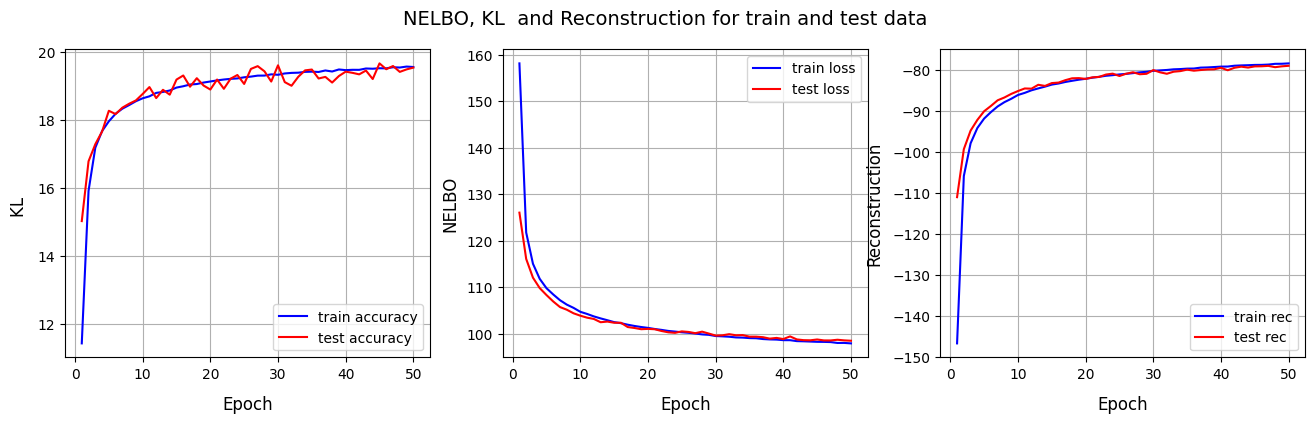

In [ ]:
vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

ls_train_loss = []
ls_train_kl = []
ls_train_recon = []
ls_val_loss = []
ls_val_kl = []
ls_val_recon = []

for epoch in tqdm(range(iter_max)):
    train_loss = 0
    train_kl = 0
    train_recon = 0
    loop_train = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="train", position=0, leave=True)
    for index, (xu, yu) in loop_train:

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae.loss(xu)

        loss.backward()
        optimizer.step()

        loop_train.set_description(f"train - epoch : {epoch}")
        loop_train.set_postfix(
                    nelbo="{}".format(summaries['train/loss'].detach().cpu().numpy()),
                    KL   ="{}".format(summaries['gen/kl_z'].detach().cpu().numpy()),
                    rec  ="{}".format(summaries['gen/rec'].detach().cpu().numpy()),
                    refresh=True,)

        train_loss  += summaries['train/loss'].detach().cpu().numpy()
        train_kl    += summaries['gen/kl_z'].detach().cpu().numpy()
        train_recon += summaries['gen/rec'].detach().cpu().numpy()

    val_loss, val_kl, val_recon = validation(vae, epoch)

    ls_train_loss.append(train_loss / len(train_loader))
    ls_train_kl.append(train_kl   / len(train_loader))
    ls_train_recon.append(train_recon/ len(train_loader))
    ls_val_loss.append(val_loss)
    ls_val_kl.append(val_kl)
    ls_val_recon.append(val_recon)



save_report(ls_train_loss, ls_train_kl, ls_train_recon, ls_val_loss, ls_val_kl, ls_val_recon)
plot_acc_loss(ls_train_loss, ls_train_kl, ls_train_recon, ls_val_loss, ls_val_kl, ls_val_recon)

## IWAE Tests

### Loss on test set with nelbo

In [ ]:
vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

val_loss, val_kl, val_recon = validation(vae, 1)

Validation - epoch : 1: 100%|██████████| 100/100 [00:01<00:00, 55.69it/s, KL=0.30526918172836304, nelbo=546.8663330078125, rec=-546.5610961914062]

In [ ]:
val_loss, val_kl, val_recon = validation(vae, 1)

Validation - epoch : 1: 100%|██████████| 100/100 [00:03<00:00, 29.73it/s, KL=19.559810638427734, nelbo=99.45643615722656, rec=-79.89662170410156]

### Loss on test set with IWAE - 5

In [ ]:
vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

val_loss, val_kl, val_recon = validation(vae, 1)

Validation - epoch : 1: 100%|██████████| 100/100 [00:01<00:00, 53.15it/s, KL=0.37245887517929077, nelbo=545.2730102539062, rec=-546.187255859375]

In [ ]:
val_loss, val_kl, val_recon = validation(vae, 1)

Validation - epoch : 1: 100%|██████████| 100/100 [00:01<00:00, 54.30it/s, KL=18.875499725341797, nelbo=96.5013198852539, rec=-77.62581634521484]

### Loss on test set with IWAE - 50

In [ ]:
vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

val_loss, val_kl, val_recon = validation(vae, 1)

Validation - epoch : 1: 100%|██████████| 100/100 [00:02<00:00, 46.28it/s, KL=0.3449932932853699, nelbo=544.4006958007812, rec=-545.5133666992188]

In [ ]:
val_loss, val_kl, val_recon = validation(vae, 1)

Validation - epoch : 1: 100%|██████████| 100/100 [00:03<00:00, 31.14it/s, KL=18.62396240234375, nelbo=95.56156158447266, rec=-76.9375991821289]

### Loss on test set with IWAE - 150

In [ ]:
vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

val_loss, val_kl, val_recon = validation(vae, 1)

Validation - epoch : 1: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s, KL=0.28802040219306946, nelbo=545.723388671875, rec=-546.5172119140625]

In [ ]:
val_loss, val_kl, val_recon = validation(vae, 1)

Validation - epoch : 1: 100%|██████████| 100/100 [00:01<00:00, 50.07it/s, KL=19.199417114257812, nelbo=96.57144165039062, rec=-77.37203216552734]